# Brazilian E-Commerce Dataset

## 1.0 About the dataset

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

## 2.0 Importing necessary libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random # random
import matplotlib.pyplot as plt # visualisation
import seaborn as sns # visualisation
from sklearn.preprocessing import MinMaxScaler # scaler
from sklearn.model_selection import train_test_split # train_test_split
from sklearn.linear_model import LinearRegression # linear regression model
from sklearn.metrics import mean_squared_error # mse
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
!pip install deep_translator
! pip install squarify
import squarify
from deep_translator import GoogleTranslator
from wordcloud import WordCloud
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Obtaining dependency information for deep_translator from https://files.pythonhosted.org/packages/38/3f/61a8ef73236dbea83a1a063a8af2f8e1e41a0df64f122233938391d0f175/deep_translator-1.11.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


## 3.0 Reading the data

In [3]:
df_path = '../input/brazilian-ecommerce/'
df_customers = pd.read_csv(df_path + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(df_path + 'olist_geolocation_dataset.csv')
df_orders = pd.read_csv(df_path + 'olist_orders_dataset.csv')
df_order_items = pd.read_csv(df_path + 'olist_order_items_dataset.csv')
df_order_payments = pd.read_csv(df_path + 'olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv(df_path + 'olist_order_reviews_dataset.csv')
df_products = pd.read_csv(df_path + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(df_path + 'olist_sellers_dataset.csv')
df_translations=pd.read_csv(df_path + 'product_category_name_translation.csv')

## 4.0 Data Cleaning

### 4.1 Data Merging

In [4]:
# Merging relevant datasets
df_merged=pd.merge(df_customers,df_orders,on='customer_id',how='inner')
df_merged=pd.merge(df_merged,df_order_items,on='order_id',how='inner')
df_merged=pd.merge(df_merged,df_products,on='product_id',how='inner')
df_merged=pd.merge(df_merged,df_sellers,on='seller_id',how='inner')
df_merged=pd.merge(df_merged,df_order_reviews,on='order_id',how='inner')
df_merged=pd.merge(df_merged,df_order_payments,on='order_id',how='inner')
df_merged=pd.merge(df_merged,df_translations,on='product_category_name',how='inner')
# Keeping a copy of merged dataset aside
df_merged_cp=df_merged.copy()
# Shape of merged dataset
df_merged.shape

(115609, 40)

Creating a custom function that returns info of the dataframe

In [5]:
def column_summary(df):
    """
    Print column name, dtype, number of missing values, number of unique values,
    first value, and last value for each column in the DataFrame.

    Parameters:
    - dataframe: pd.DataFrame, input DataFrame

    Returns:
    - summary_df: pd.DataFrame, DataFrame containing column summary information
    """
    # Initializing an empty list to store column summary information
    summary_data = []
    
    for column in df.columns:
        col_dtype=df[column].dtype
        missing_values=df[column].isnull().sum()
        unique_values=df[column].nunique()
        first_value=df[column].iloc[0]
        last_value=df[column].iloc[-1]
        # Appending column summary information to the list
        summary_data.append([column,str(col_dtype),missing_values,unique_values,first_value,last_value])
    # Create a DataFrame from the list
    summary_df=pd.DataFrame(summary_data,columns=['Column','Dtype','Missing Values','Unique Values','First Value','Last Value'])
    # Returning the DataFrame if needed for further analysis
    return summary_df

In [6]:
print(column_summary(df_merged))

                           Column    Dtype  Missing Values  Unique Values  \
0                     customer_id   object               0          96516   
1              customer_unique_id   object               0          93396   
2        customer_zip_code_prefix    int64               0          14907   
3                   customer_city   object               0           4093   
4                  customer_state   object               0             27   
5                        order_id   object               0          96516   
6                    order_status   object               0              7   
7        order_purchase_timestamp   object               0          95989   
8               order_approved_at   object              14          88332   
9    order_delivered_carrier_date   object            1195          79241   
10  order_delivered_customer_date   object            2400          93702   
11  order_estimated_delivery_date   object               0            449   

Missing values are in the columns **order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_comment_title,review_comment_message**. 

### 4.2 Handling Missing Values

Dropping all the rows with respect to datetime columns i.e **order_approved_at,order_delivered_carrier_date,order_delivered_customer_date** columns.

In [7]:
df_merged.dropna(subset=['order_approved_at','order_delivered_carrier_date','order_delivered_customer_date'],inplace=True)

Checking the rows, in which the **product_weight_g,product_length_cm,product_height_cm,product_width_cm** values are missing.

In [8]:
df_merged[['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']][df_merged.product_weight_g.isna()]

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
39465,NaN,NaN,NaN,NaN


Dropping the entire row as it has all product values missing and resetting the index.

In [9]:
df_merged.drop(39465,inplace=True)
df_merged.reset_index(inplace=True,drop=True)

Keeping **review_comment_title,review_comment_message** columns aside which can be handled later.

### 4.3 Feature Engineering

#### Converting the datetime features from object to datetime

In [10]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged['order_estimated_delivery_date'] = pd.to_datetime(df_merged['order_estimated_delivery_date'])
df_merged['shipping_limit_date'] = pd.to_datetime(df_merged['shipping_limit_date'])
df_merged['order_delivered_carrier_date'] =pd.to_datetime(df_merged['order_delivered_carrier_date'])

#### Creating new features from the existing datetime features

Number of days estimated to deliver the product.

In [11]:
df_merged['estimated_days'] = (df_merged['order_estimated_delivery_date'] - df_merged['order_purchase_timestamp']).dt.days

Number of days it took to deliver the product.

In [12]:
df_merged['arrival_days'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.days

Number of days between the day product delivered and the day product handed over to carrier to ship.

In [13]:
df_merged['shipping_days'] = (df_merged['order_delivered_customer_date'] - df_merged['order_delivered_carrier_date']).dt.days

Dropping the rows where **shipping days** is less than 0.

In [14]:
df_merged.drop((df_merged[['order_delivered_carrier_date', 'order_delivered_customer_date']][df_merged.shipping_days < 0]).index, inplace= True)

Shipping Status from Seller to Carrier

In [15]:
# Getting number of days it took between seller and carrier
df_merged['seller_to_carrier_status'] = (df_merged['shipping_limit_date'] - df_merged['order_delivered_carrier_date']).dt.days

# Then getting the status of seller to carrier
df_merged['seller_to_carrier_status'] = df_merged['seller_to_carrier_status'].apply(lambda x : 'OnTime/Early' if x >=0 else 'Late')

Shipping Status from Carrier to Customer

In [16]:
# Getting number of days it took between carrier and customer\
df_merged['arrival_status'] = (df_merged['order_estimated_delivery_date'] - df_merged['order_delivered_customer_date']).dt.days

# Then getting status of carrier to customer
df_merged['arrival_status'] = df_merged['arrival_status'].apply(lambda x: 'OnTime/Early' if x>0 else 'Late')

Removing outliers i.e rows where estimated and arrival days are greater than 60 days. 

In [17]:
# Getting indices of the rows where outliers are present
outlier_indices = df_merged[(df_merged.estimated_days>60) | (df_merged.arrival_days>60)].index

# Dropping rows wrt to outlier indices
df_merged.drop(outlier_indices, inplace=True)

# Resetting the index
df_merged.reset_index(inplace=True, drop=True)

Classifying/Rating estimated delivery time

In [18]:
def rates(days):
    """
    Categorizes delivery times into different speed categories based on the number of days.

    Parameters:
    - days: int, the number of days for delivery

    Returns:
    - str, a string representing the delivery speed category:
        - 'Very Fast' for 0 to 7 days
        - 'Fast' for 8 to 15 days
        - 'Neutral' for 16 to 24 days
        - 'Slow' for 25 to 39 days
        - 'Very Slow' for 40 days and above
    """
    if days in range(0,8):
        return 'Very Fast'
    elif days in range(8,16):
        return 'Fast'
    elif days in range(16,25):
        return 'Neutral'
    elif days in range(25,40):
        return 'Slow'
    else:
        return 'Very Slow'

Applying the rates function on our data

In [19]:
df_merged['estimated_delivery_rate'] = df_merged['estimated_days'].apply(rates)
df_merged['arrival_delivery_rate'] = df_merged['arrival_days'].apply(rates)
df_merged['shipping_delivery_rate'] = df_merged['shipping_days'].apply(rates)

### Creating new features from Product Features

Categorising/Classifying/Merging all categories into 9 main categories.

In [20]:
def classify_cat(category):
    
    """
    Classifies product categories into broader thematic groups.

    Parameters:
    - category: str, the specific product category

    Returns:
    - str, the broader thematic group to which the product category belongs:
        - 'Furniture' for furniture-related categories
        - 'Beauty & Health' for beauty and health-related categories
        - 'Books & Stationery' for book and stationery-related categories
        - 'Entertainment' for entertainment-related categories
        - 'Electronics' for electronics-related categories
        - 'Fashion' for fashion-related categories
        - 'Food & Drinks' for food and drinks-related categories
        - 'Home & Garden' for home and garden-related categories
        - 'Industry & Construction' for industry and construction-related categories
    """
    
    if category in ['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'home_comfort', 'home_comfort_2', 'home_construction', 'garden_tools', 'furniture_bedroom', 'furniture_mattress_and_upholstery']:
        return 'Furniture'
    
    elif category in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Beauty & Health'
    
    elif category in ['books_general_interest', 'books_technical', 'books_imported', 'stationery']:
        return 'Books & Stationery'
    
    elif category in ['sports_leisure', 'toys', 'cds_dvds_musicals', 'music', 'dvds_blu_ray', 'cine_photo', 'party_supplies', 'christmas_supplies', 'arts_and_craftmanship', 'art']:
        return 'Entertainment'
    
    elif category in ['auto', 'computers_accessories', 'musical_instruments', 'consoles_games', 'watches_gifts', 'air_conditioning', 'telephony', 'electronics', 'fixed_telephony', 'tablets_printing_image', 'computers', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'audio', 'signaling_and_security', 'security_and_services']:
        return 'Electronics'
    
    elif category in ['fashio_female_clothing', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'baby', 'cool_stuff', ]:
        return 'Fashion'
    
    elif category in ['food_drink', 'drinks', 'food']:
        return 'Food & Drinks'
    
    elif category in ['housewares', 'home_confort', 'home_appliances', 'home_appliances_2', 'flowers', 'costruction_tools_garden', 'garden_tools', 'construction_tools_lights', 'costruction_tools_tools', 'luggage_accessories', 'la_cuisine', 'pet_shop', 'market_place']:
        return 'Home & Garden'
    
    elif category in ['construction_tools_construction', 'construction_tools_safety', 'industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Construction'

Applying classify_cat function on our data

In [21]:
df_merged['product_category'] = df_merged['product_category_name_english'].apply(classify_cat)

Checking count of each category

In [22]:
df_merged['product_category'].value_counts()

product_category
Electronics                29453
Furniture                  27791
Entertainment              13451
Beauty & Health            13224
Home & Garden              12780
Fashion                     9680
Books & Stationery          3413
Industry & Construction     1630
Food & Drinks               1146
Name: count, dtype: int64

Creating and Calculating Product Volume from Product Length, Width, Height

In [23]:
# Creating new column Volume
df_merged['product_vol_cm3'] = df_merged['product_length_cm'] * df_merged['product_width_cm'] * df_merged['product_height_cm']


Checking order status distribution

In [24]:
df_merged['order_status'].value_counts()

order_status
delivered    112561
canceled          7
Name: count, dtype: int64

Dropping order_status column due to imbalance abd lack of variance

In [25]:
df_merged.drop('order_status',axis=1,inplace=True)

Checking payment_installments distribution

In [26]:
df_merged['payment_installments'].value_counts()

payment_installments
1     56131
2     13095
3     11259
4      7646
10     6576
5      5779
8      4844
6      4417
7      1723
9       685
12      157
15       85
18       38
24       34
11       22
20       19
13       18
14       15
16        7
17        7
21        6
0         3
23        1
22        1
Name: count, dtype: int64

Getting indices of rows where payment_installment value is 0

In [27]:
df_merged[df_merged['payment_installments']==0]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,estimated_days,arrival_days,shipping_days,seller_to_carrier_status,arrival_status,estimated_delivery_rate,arrival_delivery_rate,shipping_delivery_rate,product_category,product_vol_cm3
40631,48ebb06cf56dba9d009230cc751bb195,9925e1d7dff0d807355599dee04830ab,44001,feira de santana,BA,1a57108394169c0b47d8f876acc9ba2d,2018-05-15 16:25:14,2018-05-15 16:36:52,2018-05-17 12:37:00,2018-05-24 15:45:41,...,21,8,7,OnTime/Early,OnTime/Early,Neutral,Fast,Very Fast,Home & Garden,5819.0
40632,48ebb06cf56dba9d009230cc751bb195,9925e1d7dff0d807355599dee04830ab,44001,feira de santana,BA,1a57108394169c0b47d8f876acc9ba2d,2018-05-15 16:25:14,2018-05-15 16:36:52,2018-05-17 12:37:00,2018-05-24 15:45:41,...,21,8,7,OnTime/Early,OnTime/Early,Neutral,Fast,Very Fast,Home & Garden,5819.0
96886,5e5794daaa13f73e2f1cdb4114529843,f54cea27c80dc09bfe07b1cf1e01b845,5263,sao paulo,SP,744bade1fcf9ff3f31d860ace076d422,2018-04-22 11:34:42,2018-04-24 19:04:46,2018-04-24 03:14:34,2018-04-27 20:55:28,...,23,5,3,OnTime/Early,OnTime/Early,Neutral,Very Fast,Very Fast,Electronics,1560.0


Dropping the rows which have the payment_installments value as 0

In [28]:
df_merged.drop([40631,40632,96886],inplace=True)
df_merged.reset_index(inplace=True,drop=True)

## 5.0 Exploratory Data Analysis (EDA)

### 5.1 Univariate Analysis

Top 10 Customer Capacity Cities

Text(0.5, 1.0, 'Top 10 Customer Capacity Cities')

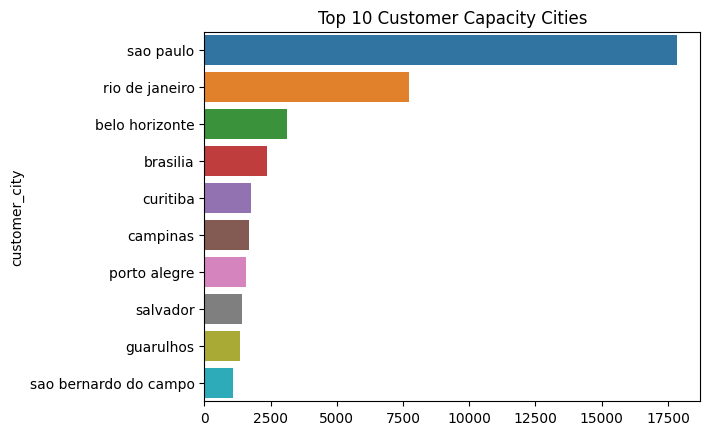

In [29]:
sns.barplot(x=df_merged['customer_city'].value_counts().values[:10],y=df_merged['customer_city'].value_counts().index[:10])
plt.title('Top 10 Customer Capacity Cities')

Top 10 Customer Capacity States

Text(0.5, 1.0, 'Top 10 Customer Capacity States')

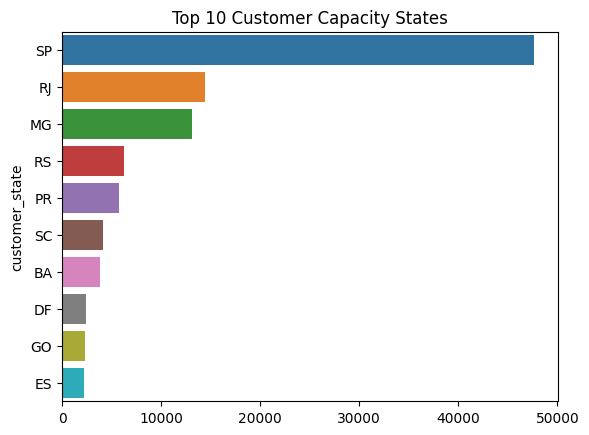

In [30]:
sns.barplot(x=df_merged['customer_state'].value_counts().values[:10],y=df_merged['customer_state'].value_counts().index[:10])
plt.title('Top 10 Customer Capacity States')

Top 10 Seller Capacity Cities

Text(0.5, 1.0, 'Top 10 Seller Capacity Cities')

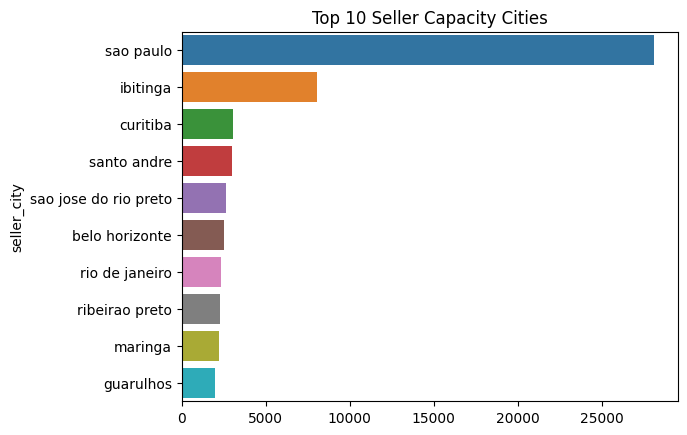

In [31]:
sns.barplot(x = df_merged['seller_city'].value_counts().values[:10], y= df_merged['seller_city'].value_counts().index[:10])
plt.title('Top 10 Seller Capacity Cities')

Top 10 Seller Capacity States

Text(0.5, 1.0, 'Top 10 Seller Capacity States')

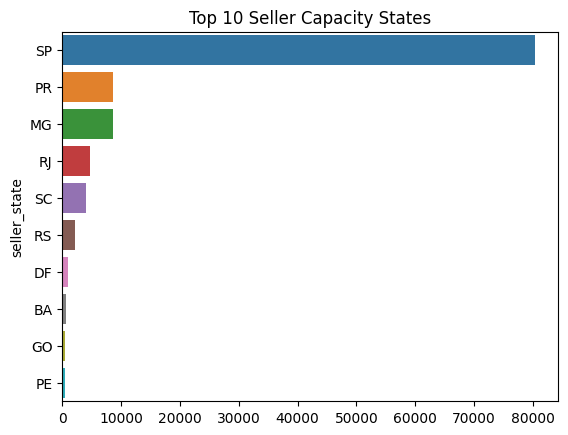

In [32]:
sns.barplot(x = df_merged['seller_state'].value_counts().values[:10], y= df_merged['seller_state'].value_counts().index[:10])
plt.title('Top 10 Seller Capacity States')

Price Distribution

/tmp/ipykernel_48/4151503230.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_merged['price'])


Text(0.5, 1.0, 'Price Distribution')

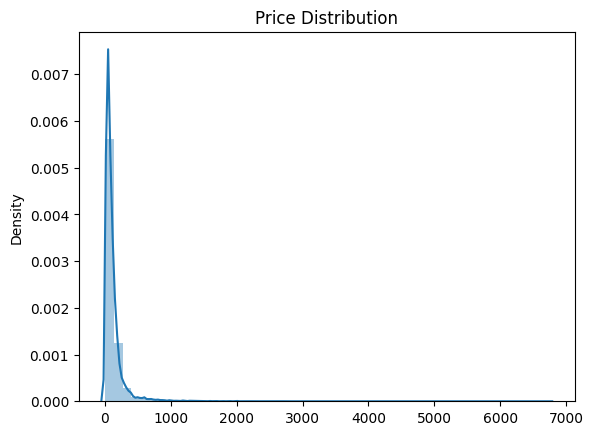

In [33]:
sns.distplot(x=df_merged['price'])
plt.title('Price Distribution')

Freight Value Distribution

/tmp/ipykernel_48/2012527661.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_merged['freight_value'])


Text(0.5, 1.0, 'Freight Value Distribution')

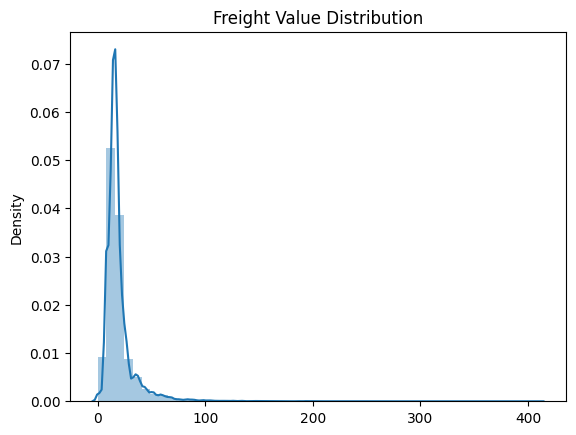

In [34]:
sns.distplot(x=df_merged['freight_value'])
plt.title('Freight Value Distribution')

Product Volume Distribution

/tmp/ipykernel_48/2297127867.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_merged['product_vol_cm3'])


Text(0.5, 1.0, 'Product Volume Distribution')

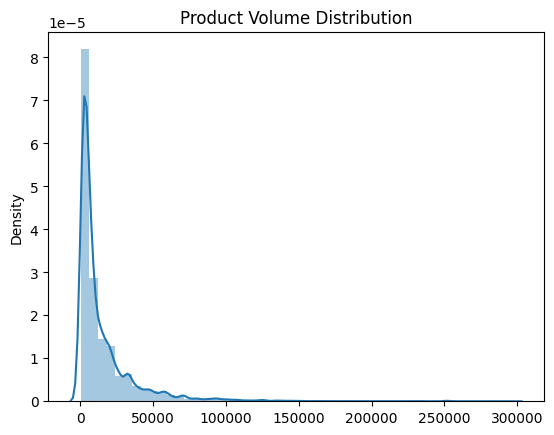

In [35]:
sns.distplot(x=df_merged['product_vol_cm3'])
plt.title('Product Volume Distribution')

Number of orders per each Category

Text(0.5, 1.0, 'Number of orders per each Category')

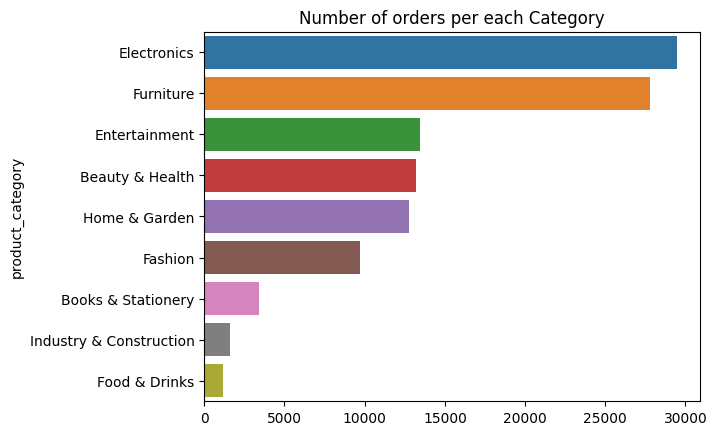

In [36]:
sns.barplot(x=df_merged['product_category'].value_counts().values,y=df_merged['product_category'].value_counts().index)
plt.title('Number of orders per each Category')

Review Score

Text(0.5, 1.0, 'Review Score')

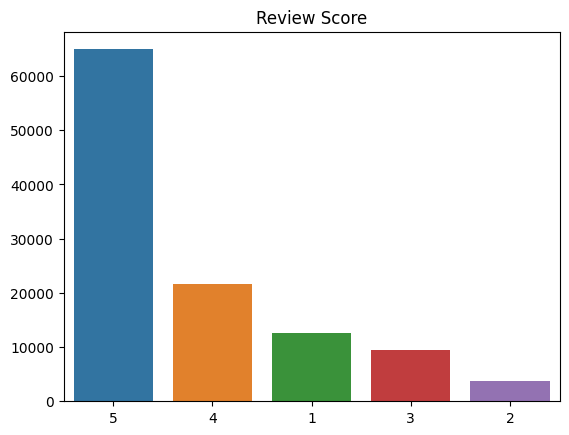

In [37]:
review_score_index = [str(i) for i in df_merged['review_score'].value_counts().index]
sns.barplot(x = review_score_index, y= df_merged['review_score'].value_counts().values)
plt.title('Review Score')

Payment Value Distribution

/tmp/ipykernel_48/692555714.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df_merged['payment_value'])


Text(0.5, 1.0, 'Payment Value Distribution')

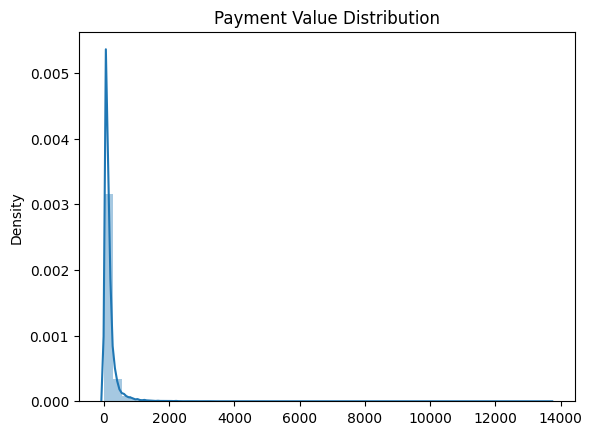

In [38]:
sns.distplot(x = df_merged['payment_value'])
plt.title('Payment Value Distribution')

Payment Type Distribution

Text(0.5, 1.0, 'Payment Type Distribution')

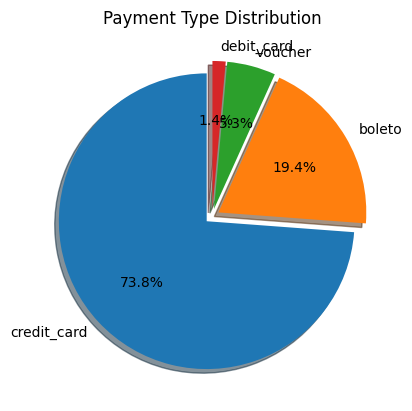

In [39]:
plt.pie(df_merged['payment_type'].value_counts().values, explode=(0.05, 0.05, 0.05, 0.05), labels= df_merged['payment_type'].value_counts().index, autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Payment Type Distribution')

Payment Installments Distribution

Text(0.5, 1.0, 'Payment Installments Distribution')

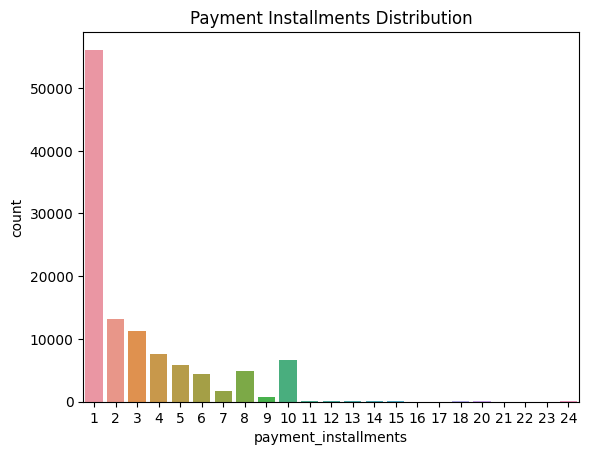

In [40]:
sns.countplot(x = df_merged['payment_installments'])
plt.title('Payment Installments Distribution')

### 5.2 Multivariate Analysis

Cities Revenue-wise

Text(0, 0.5, 'Total Payments in Millions')

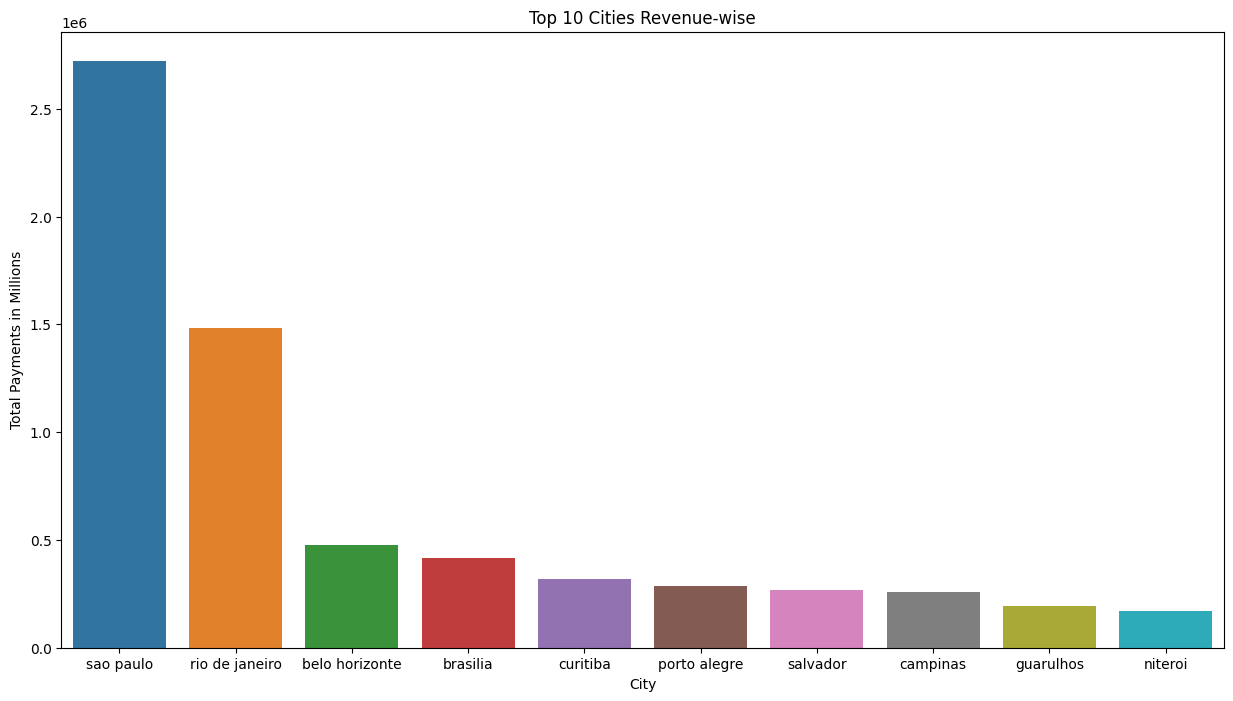

In [41]:
# Grouping cities by payment value
revenue_per_city = df_merged.groupby('customer_city')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)
revenue_per_city.reset_index(inplace=True)

# Plotting cities revenue-wise
plt.figure(figsize=[15, 8])
sns.barplot(x = revenue_per_city.customer_city[:10], y= revenue_per_city.payment_value[:10])
plt.title('Top 10 Cities Revenue-wise')
plt.xlabel('City')
plt.ylabel('Total Payments in Millions')

Average Review Score per Product Category

Text(0, 0.5, 'Prodcut Category')

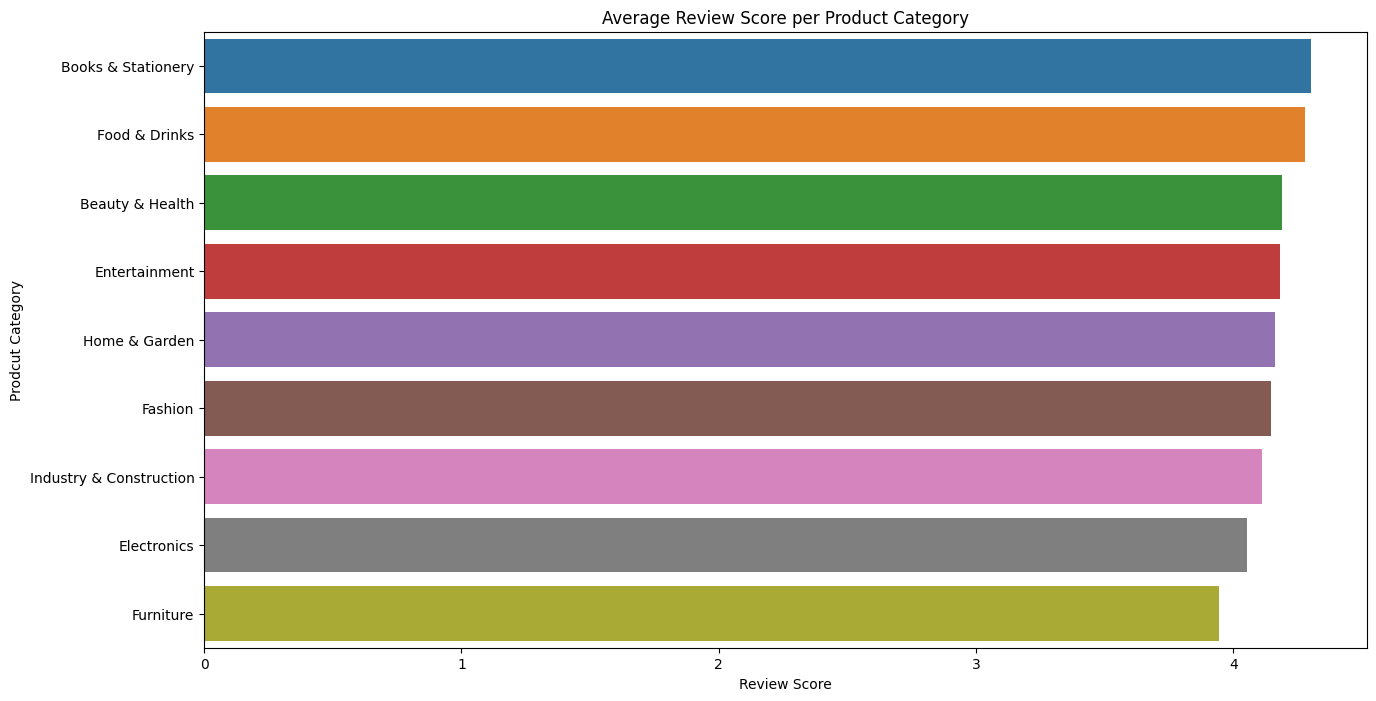

In [42]:
# Calculating average review score per product category
review_per_cat = df_merged.groupby('product_category')[['review_score']].mean().sort_values(by='review_score', ascending=False)
review_per_cat.reset_index(inplace=True)

# Plotting Product Category vs Review Score
plt.figure(figsize=[15, 8])
sns.barplot(x = review_per_cat.review_score, y= review_per_cat.product_category)
plt.title('Average Review Score per Product Category')
plt.xlabel('Review Score')
plt.ylabel('Prodcut Category')

Average Payment value per Payment type

Text(0, 0.5, 'Average Payment Value')

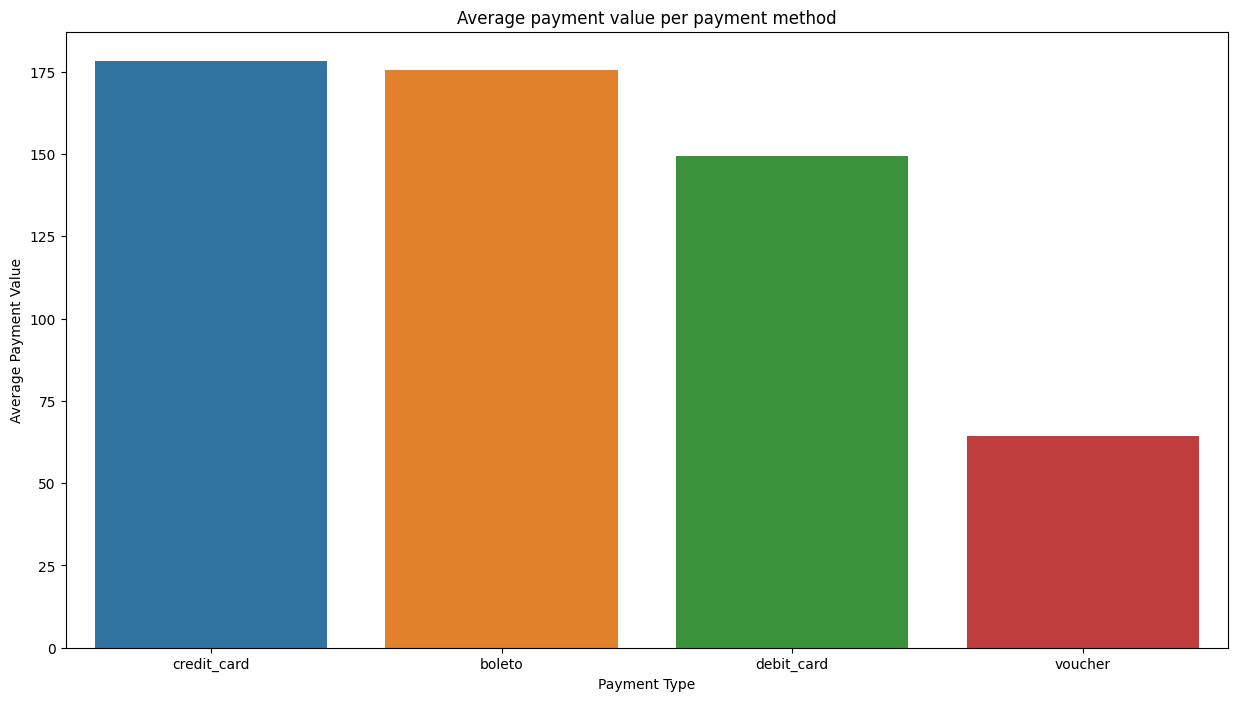

In [43]:
# Groupping each payment type by average payment value
payment_methods = df_merged.groupby('payment_type')[['payment_value']].mean().sort_values(by='payment_value', ascending=False)
payment_methods.reset_index(inplace=True)

# Plotting Average payments per payment method
plt.figure(figsize=[15, 8])
sns.barplot(x = payment_methods.payment_type, y= payment_methods.payment_value)
plt.title('Average payment value per payment method')
plt.xlabel('Payment Type')
plt.ylabel('Average Payment Value')

Total Revenue per Payment Method

Text(0, 0.5, 'Revenue per Payment type (Millions)')

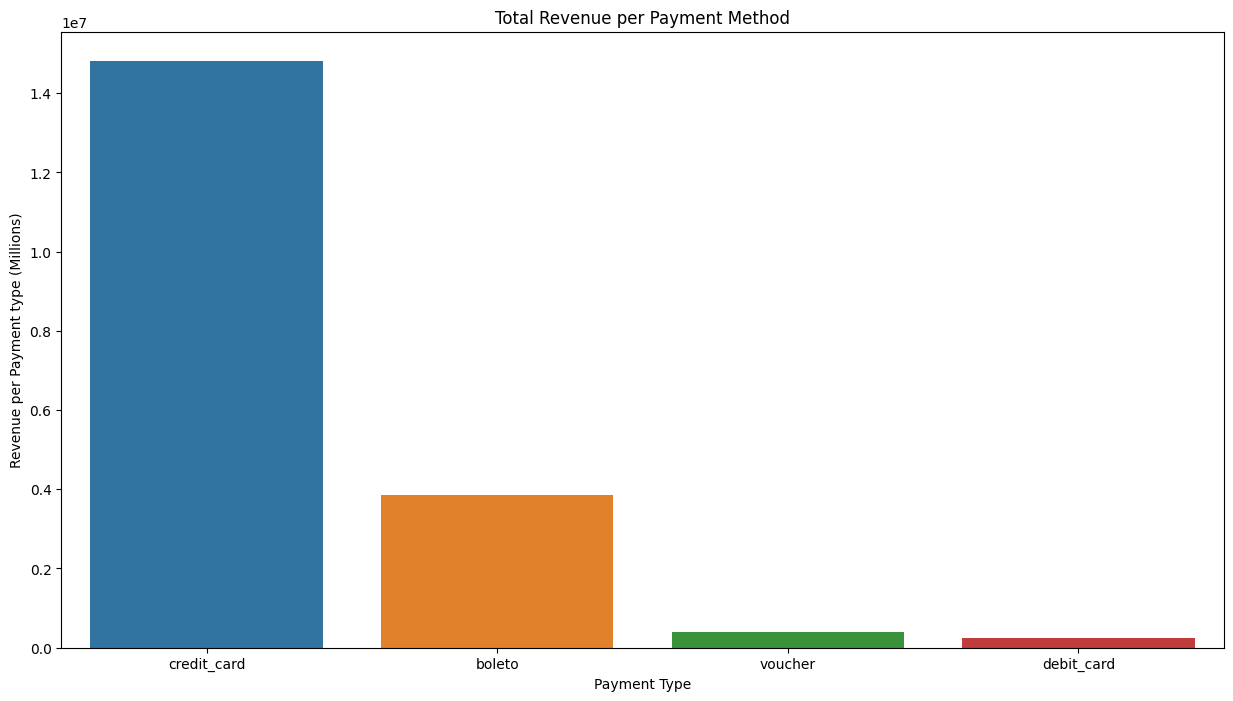

In [44]:
# Groupping each payment type by average payment value
payment_methods = df_merged.groupby('payment_type')[['payment_value']].sum().sort_values(by='payment_value', ascending=False)
payment_methods.reset_index(inplace=True)

# plotting Average payments per payment method
plt.figure(figsize=[15, 8])
sns.barplot(x = payment_methods.payment_type, y= payment_methods.payment_value)
plt.title('Total Revenue per Payment Method')
plt.xlabel('Payment Type')
plt.ylabel('Revenue per Payment type (Millions)')

Average Freight value per Product Category

Text(0, 0.5, 'Product Category')

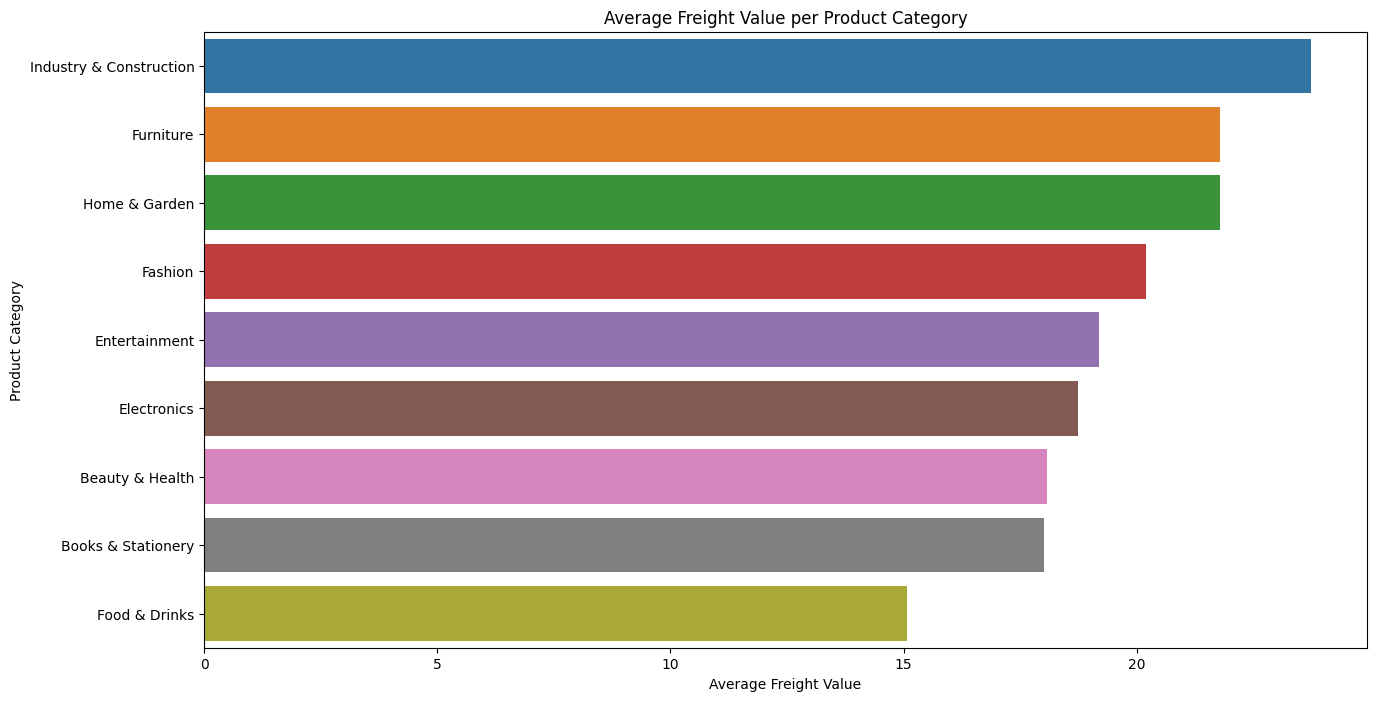

In [45]:
# Grouping product category by average freight value
freight_per_cat = df_merged.groupby('product_category')[['freight_value']].mean().sort_values(by='freight_value', ascending=False)
freight_per_cat.reset_index(inplace=True)

# Plotting average freight value per product category
plt.figure(figsize=[15, 8])
sns.barplot(x = freight_per_cat.freight_value, y=  freight_per_cat.product_category)
plt.title('Average Freight Value per Product Category')
plt.xlabel('Average Freight Value')
plt.ylabel('Product Category')

Estimated Delivery Dates rating Distribution

Text(0.5, 1.0, 'Estimated Delivery Date rating Distribution')

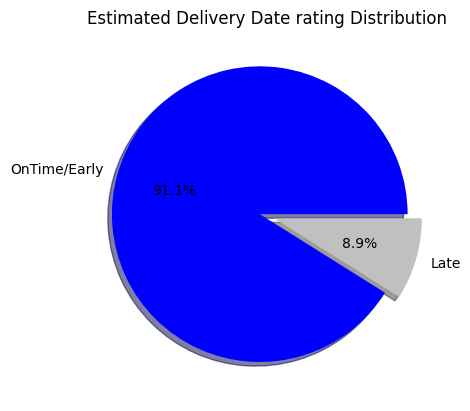

In [46]:
Values = df_merged['arrival_status'].value_counts().values
Labels = df_merged['arrival_status'].value_counts().index
plt.pie(Values, explode=(0.05, 0.05), labels= ['OnTime/Early', 'Late'], autopct='%1.1f%%', shadow=True, colors= ('#0000FF', '#C0C0C0'))
plt.title('Estimated Delivery Date rating Distribution')

Average Shipping Time per Product Category

Text(0, 0.5, 'Product Category')

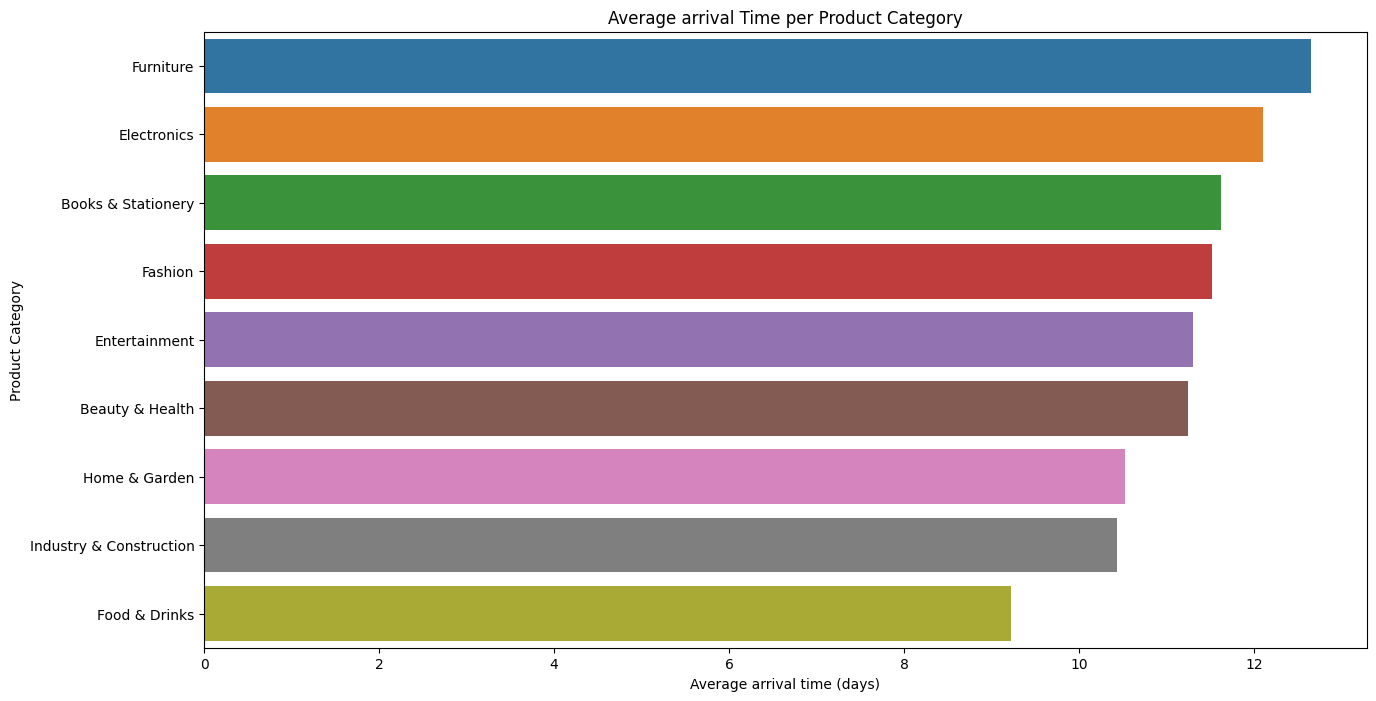

In [47]:
# Grouping product category by average arrival time
ship_per_cat = df_merged.groupby('product_category')[['arrival_days']].mean().sort_values(by='arrival_days', ascending=False)

ship_per_cat.reset_index(inplace=True)

# Plotting average freight value per Product Category
plt.figure(figsize=[15, 8])
sns.barplot(x = ship_per_cat.arrival_days, y=  ship_per_cat.product_category)
plt.title('Average arrival Time per Product Category')
plt.xlabel('Average arrival time (days)')
plt.ylabel('Product Category')

Review Score Transaction Wise

Text(0, 0.5, 'Count of Transactions')

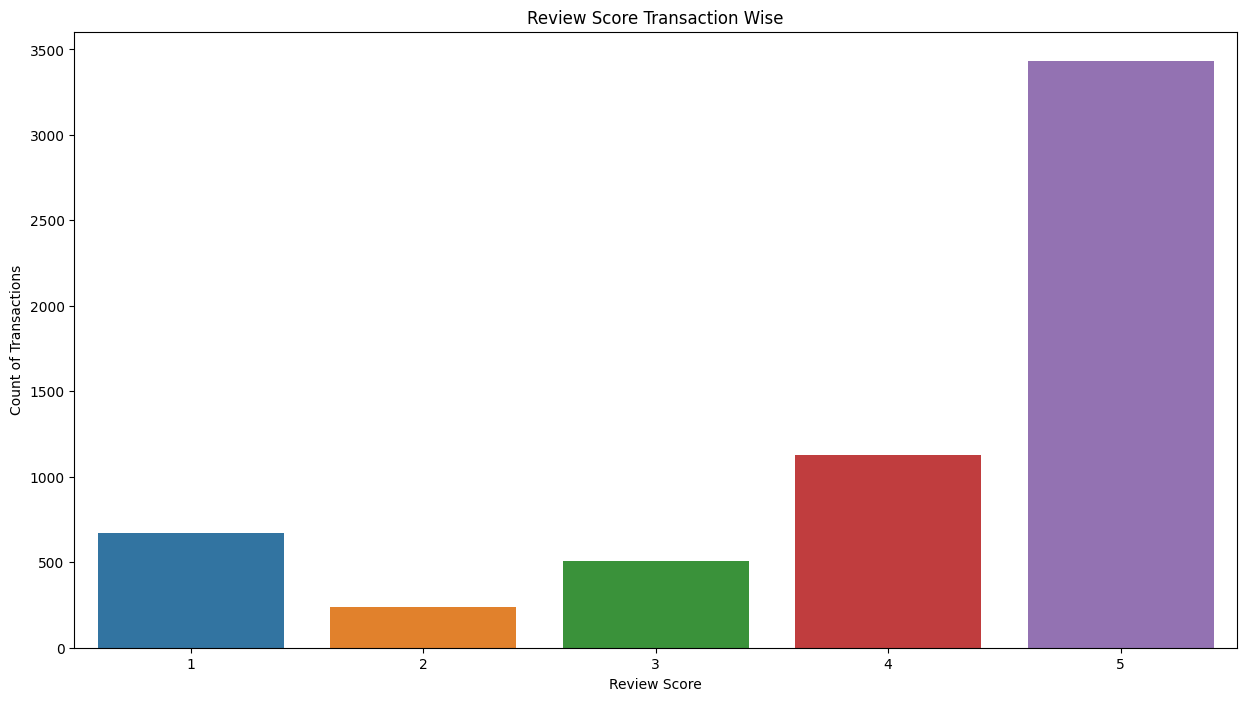

In [48]:
plt.figure(figsize=[15, 8])
voucher_trans = df_merged[df_merged['payment_type'] == 'voucher']
sns.countplot(x= voucher_trans.review_score)
plt.title('Review Score Transaction Wise')
plt.xlabel('Review Score')
plt.ylabel('Count of Transactions')

## 6.0 Predictive Modelling

### 6.1 Data Preprocessing

Taking relevant and necessary columns for creating a model that predicts delivery time of the product.

In [49]:
df_pmt=df_merged[['customer_state','price','product_category','product_weight_g','seller_state','estimated_days','arrival_days','shipping_days','product_vol_cm3']]

Splitting dataset into X and y.

In [50]:
X=df_pmt.drop(['arrival_days'],axis=1)
y=df_pmt['arrival_days']

Encoding categorical features into numerical features.

In [51]:
encode_features=['customer_state','product_category','seller_state']
X=pd.get_dummies(X,columns=encode_features)

Scaling numerical features.

In [52]:
numerical_features=['price','product_weight_g','estimated_days','shipping_days','product_vol_cm3']
scaler=MinMaxScaler()
X.loc[:,numerical_features] = scaler.fit_transform(X[numerical_features])

Splitting data into train and test sets.

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

### 6.2 Modelling

Creating Linear Regression model,fitting data into the model and predicting test dataset.

In [54]:
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
lin_reg_preds=lin_reg.predict(X_test)

Calculating Root Mean Squared Error.

In [55]:
rmse=np.sqrt(mean_squared_error(lin_reg_preds,y_test))

## 7.0 Time Series Analysis

Taking relevant and necessary columns for Time Series Analysis.

In [56]:
df_th=df_merged[['customer_id','customer_unique_id','customer_zip_code_prefix','order_id','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date','order_item_id','product_id','seller_id','price','freight_value','product_photos_qty','product_category','seller_zip_code_prefix','review_id','review_score','review_comment_title','review_comment_message']]
time_series_df=df_th.set_index('order_purchase_timestamp')

Resampling data for Monthly and Quarterly analysis.

In [57]:
monthly_resampled_data = time_series_df.resample('M').size()
quarterly_resampled_data = time_series_df.resample('Q').size()
yearly_resampled_data = time_series_df.resample('Y').size()

Decomposing the monthly resampled data.

In [58]:
decomposition_result = seasonal_decompose(monthly_resampled_data, model='additive', period=6)

Plotting Trend, Seasonal and Residual data of the Monthly resampled data.

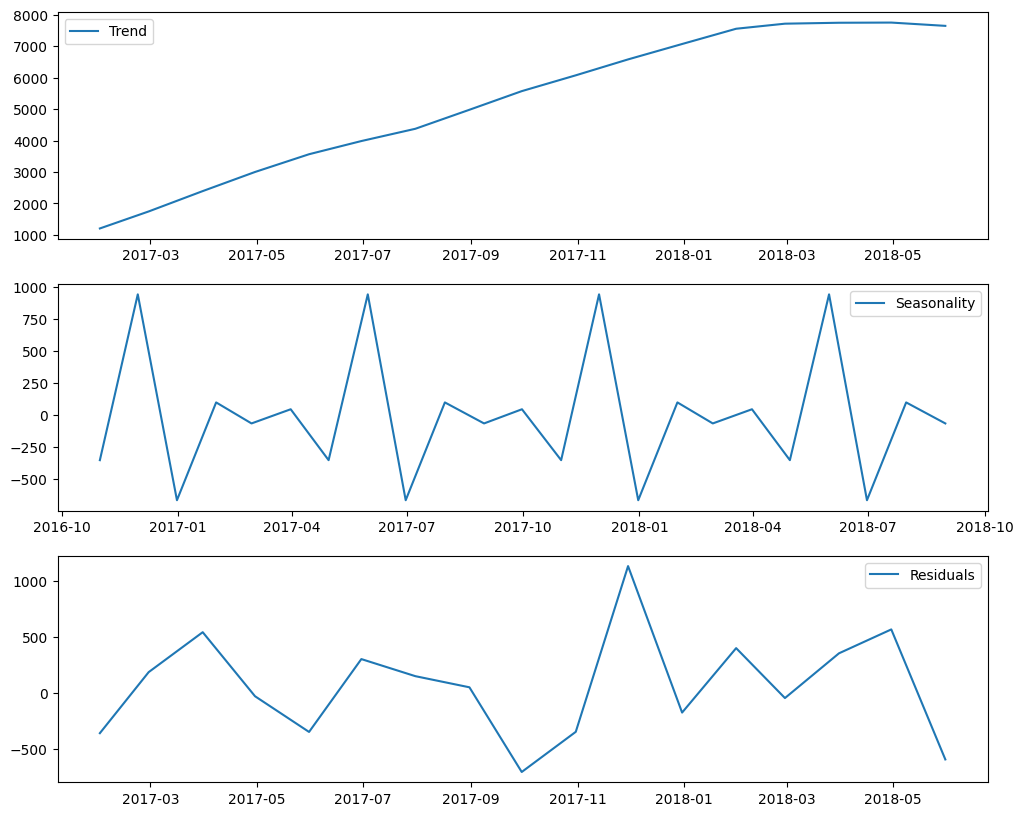

In [59]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition_result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition_result.resid, label='Residuals')
plt.legend()

plt.show()

Decomposing the quarterly resampled data.

In [60]:
decomposition_result = seasonal_decompose(quarterly_resampled_data, model='additive', period=4)


Plotting Trend, Seasonal and Residual data of the quaterly resampled data.

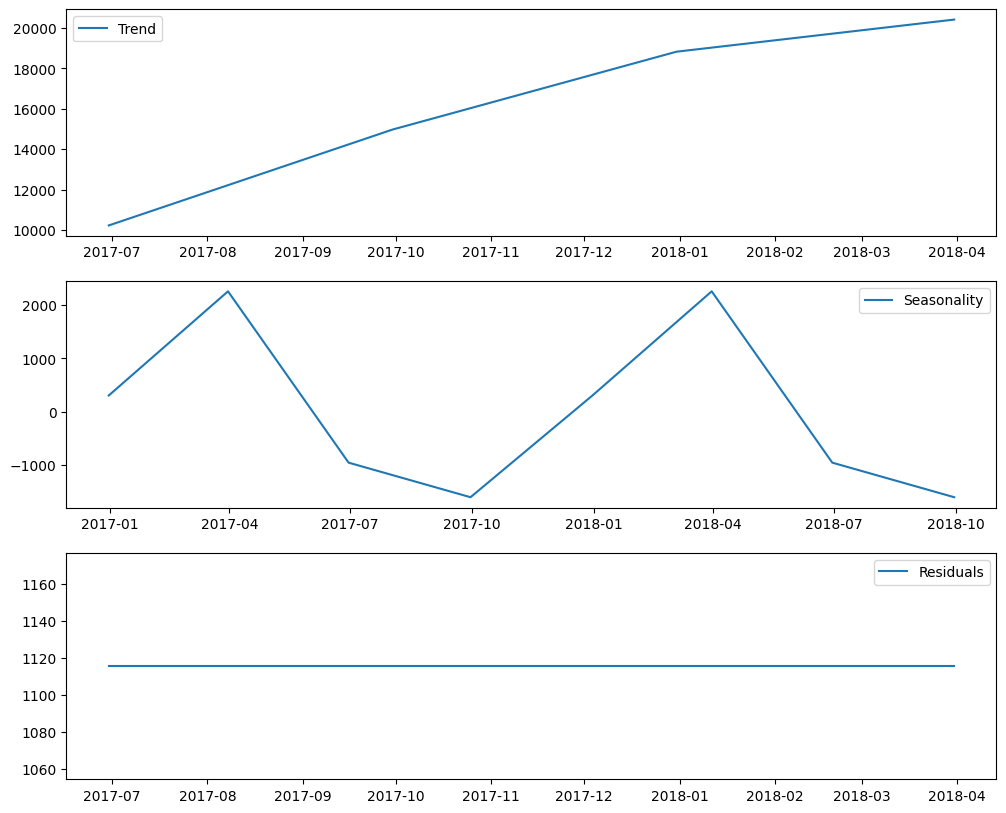

In [61]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition_result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition_result.resid, label='Residuals')
plt.legend()

plt.show()

Decomposing the yearly resampled data.

In [62]:
decomposition_result = seasonal_decompose(yearly_resampled_data, model='additive', period=1)

Plotting Trend, Seasonal and Residual of the yearly resampled data.

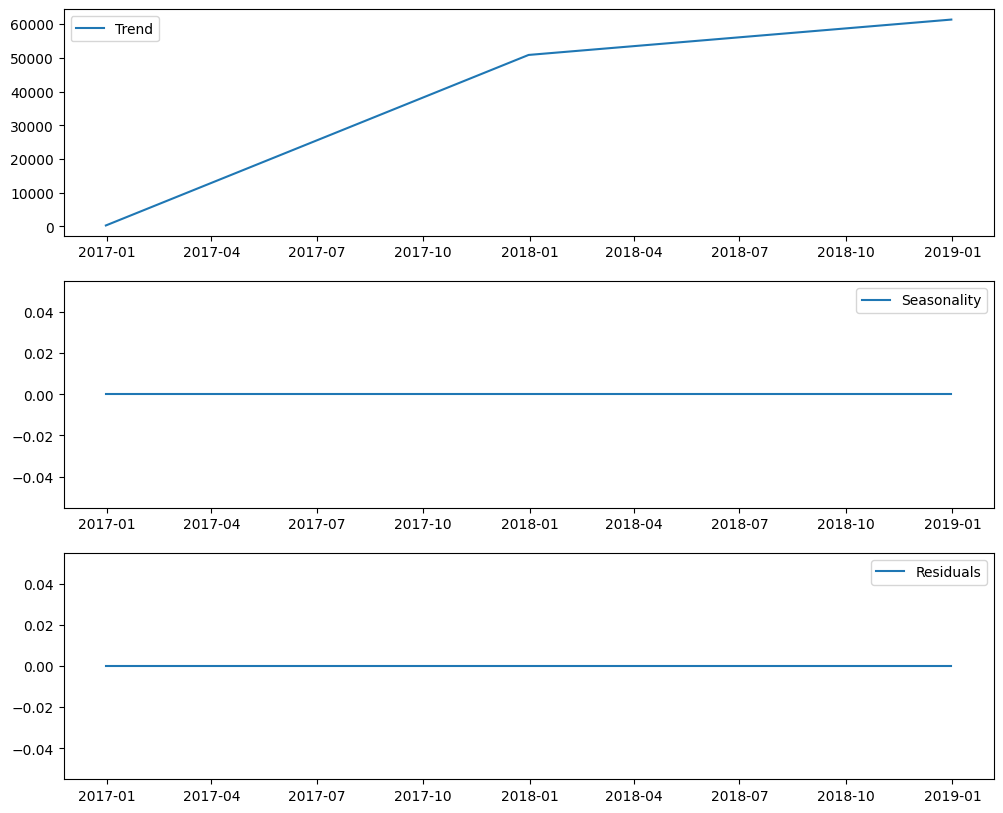

In [63]:
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(decomposition_result.trend, label='Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition_result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(decomposition_result.resid, label='Residuals')
plt.legend()

plt.show()

Dropping null values (if present) in quarterly resampled data.

In [64]:
quarterly_resampled_data = quarterly_resampled_data.dropna()

Converting data to float data type.

In [65]:
quarterly_resampled_data = quarterly_resampled_data.astype(float)

Predicting the next quarter.

In [79]:
# SARIMA model parameters (replace these with the best parameters from auto_arima)
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 4)  # Assuming quarterly seasonality (m=4)

# Fit the SARIMA model
model = SARIMAX(quarterly_resampled_data, order=order, seasonal_order=seasonal_order)
fit_model = model.fit(disp=False)

# Forecast next 3 quarters
forecasted_data = fit_model.get_forecast(steps=1)

qf=quarterly_resampled_data._append(forecasted_data.predicted_mean)
qf

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


2016-12-31      275.000000
2017-03-31     5773.000000
2017-06-30    10385.000000
2017-09-30    14486.000000
2017-12-31    20251.000000
2018-03-31    23798.000000
2018-06-30    23198.000000
2018-09-30    14399.000000
2018-12-31     6076.809701
Freq: Q-DEC, dtype: float64

Plotting the past and predicted data.

Text(0.5, 1.0, 'Quarterly Data with next quarter prediction')

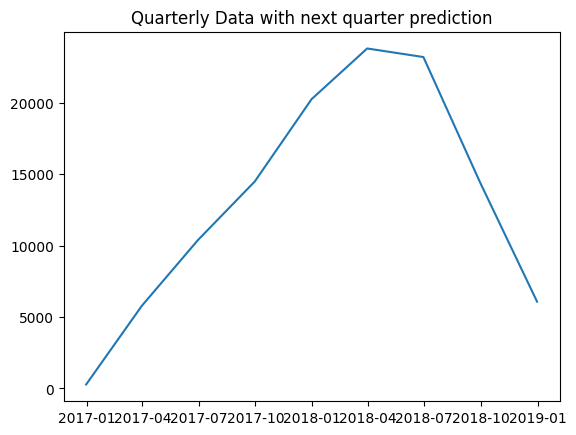

In [78]:
plt.plot(qf)
plt.title('Quarterly Data with next quarter prediction')

# 8.0 Churn Prediction

In [ ]:
df_churn = df_merged.copy()

Getting last Transaction date to calculate recency

In [ ]:
max_trans_date = max(df_churn.order_purchase_timestamp).date()
max_trans_date

Creating Recency, Frequency and Monetary Features

In [ ]:
rfm_table = df_churn.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x:(datetime.strptime(str(max_trans_date),'%Y-%m-%d') - x.max()).days,
                                                                'product_id': lambda x:len(x),
                                                             'payment_value': lambda x:sum(x)})

Renaming the columns for ease

In [ ]:
rfm_table.rename(columns={'order_purchase_timestamp':'Recency','product_id':'Frequancy','payment_value':'Monetary'}, inplace=True)
rfm_table

Creating RFM Scores

In [ ]:
rfm_table['r_score'] = pd.qcut(rfm_table['Recency'], 4, ['4','3','2','1'])
rfm_table['f_score'] = pd.qcut(rfm_table['Frequancy'].rank(method= 'first'), 4, ['1','2','3','4'])
rfm_table['m_score'] = pd.qcut(rfm_table['Monetary'], 4, ['1','2','3','4'])

Calculating RFM Scores

In [ ]:
rfm_table['rfm_score'] = 100 * rfm_table['r_score'].astype(int) + 10 * rfm_table['f_score'].astype(int)+ rfm_table['m_score'].astype(int)

Customer Segmentation based on RFM Score

In [ ]:
def customer_segmenation(rfm_score):
  
  if rfm_score == 444:
    return 'Important'
  elif  rfm_score >= 433 and rfm_score < 444:
    return 'Most Loyal'
  elif   rfm_score >=421 and rfm_score< 433:
    return 'Loyal'
  elif rfm_score>=344 and rfm_score < 421:
    return 'New customers'
  elif rfm_score>=323 and rfm_score<344:
    return 'Good customer'
  elif rfm_score>=224 and rfm_score<311:
    return 'High risk to churn' 
  else:
    return 'Lost customers'       
  
rfm_table['customer_segmentation'] = rfm_table['rfm_score'].apply(customer_segmenation)

Plotting segmented customer frequncy

In [ ]:
plt.figure(figsize=[10,6])
sns.barplot(x = rfm_table.customer_segmentation.value_counts().values, y= rfm_table.customer_segmentation.value_counts().index)

Customer Segementation Grid

In [ ]:
plt.figure(figsize=[15,8])
plt.rc('font', size=15)

Sizes = rfm_table.groupby('customer_segmentation')[['Monetary']].count()
squarify.plot(sizes= Sizes.values, label= Sizes.index, color=["red", "orange", "blue", "yellow", "fuchsia", "green", "royalblue"], alpha=.55)
plt.suptitle("Customer Segmentation Grid", fontsize=25);

## 9.0 Natural Language Processing

In [ ]:
df_order_reviews.head()

### Cleaning & Preprocessing

Taking only necessary columns for NLP i.e **review_comment_message and reviews_score**.

In [ ]:
df_reviews=df_order_reviews[['review_comment_message','review_score']]

Info our reviews data

In [ ]:
column_summary(df_reviews)

Dropping missing values

In [ ]:
df_reviews.dropna(inplace=True)

Renaming columns for ease and resetting the index

In [ ]:
df_reviews.rename(columns = {'review_comment_message' : 'comment', 'review_score' : 'score'}, inplace= True)

# Resetting the  index
df_reviews.reset_index(inplace= True, drop= True)

Encoding review scores to Satisfied/Not Satisfied.

In [ ]:
encoded_class = { 1 : 'Not Satisfied',
                  2 : 'Not Satisfied', 
                  3 : 'Not Satisfied', 
                  4 : 'Satisfied', 
                  5 : 'Satisfied'}

df_reviews['score'] = df_reviews['score'].map(encoded_class)

Text Preprocessing

In [ ]:
stemmer = PorterStemmer()
corpus = []

for i in range(df_reviews.shape[0]):
    # Removing any special characters or number
    comment = re.sub('[^a-zA-Z]', ' ', df_reviews.comment[i])
    # Lowering the text
    comment = comment.lower()
    # Removing any spaces before or after text
    comment = comment.strip()
    # Splitting text for stemming
    comment = comment.split()
    # Stemming words in Portugues
    comment = [stemmer.stem(word) for word in comment if word not in set(stopwords.words('portuguese'))]
    # Merging stemmed words to be sentences
    comment = ' '.join(comment)
    
    corpus.append(comment)

Converting text into numbers and creating a new dataframe out of it

In [ ]:
tf = TfidfVectorizer()
df_new = tf.fit_transform(corpus).toarray()
df_new = pd.DataFrame(df_new, columns= tf.get_feature_names_out())
df_new.head()

Splitting into train and test sets

In [ ]:
# Features
X = df_new
# Target
y = df_reviews['score']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify= y)

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print('Evaluation on Training \n', classification_report(y_train, nb.predict(X_train)))
print('Evaluation on Testing \n', classification_report(y_test, nb.predict(X_test)))
print('Train Data Confusion Matrix')
cf=ConfusionMatrixDisplay(confusion_matrix(y_train,nb.predict(X_train)),display_labels=nb.classes_)
cf.plot()
print('Test Data Confusion Matrix')
cft=ConfusionMatrixDisplay(confusion_matrix(y_test,nb.predict(X_test)),display_labels=nb.classes_)
cft.plot()

### Checking reasons for Non-Satisfaction

In [ ]:
# Creating seperate dataframe for not satisfied reviews and resetting the index
not_satisfied = df_reviews[df_reviews['score'] == 'Not Satisfied']
not_satisfied.reset_index(inplace=True,drop=True)

Cleaning and Preprocessing the not_satisfied dataframe

In [ ]:
stemmer = PorterStemmer()
corpus = []

for i in range(not_satisfied.shape[0]):
    comment = re.sub('[^a-zA-Z]', ' ', not_satisfied.comment[i])
    comment = comment.lower()
    comment = comment.strip()
    comment = comment.split()
    comment = [stemmer.stem(word) for word in comment if word not in set(stopwords.words('portuguese'))]
    comment = ' '.join(comment)
    
    corpus.append(comment)

Translating non-satisified comments

In [ ]:
not_satisfied_trans = []
random.seed(10)

for sentence in random.sample(corpus, 1000):
    not_satisfied_trans.append(GoogleTranslator(source='portuguese', target='english').translate(sentence))

Applying stemming to translated

In [ ]:
not_satisfied_final = []

for sent in not_satisfied_trans:

    for word in sent.split():

        if word not in set(stopwords.words('english')):

            not_satisfied_final.append(stemmer.stem(word))


### Sorting the word frequencies

In [ ]:
not_satisfied_freq = not_satisfied_freq.process_text(not_satisfied_final)
sorted_word_frequencies = sorted(not_satisfied_freq.items(), key= lambda x : x[1], reverse=True)

Plotting Words Vs Frequencies

In [ ]:
plt.figure(figsize= [20, 10])
sns.barplot(x = pd.DataFrame(sorted_word_frequencies)[1:20][0], y= pd.DataFrame(sorted_word_frequencies)[1:20][1], palette= 'crest_r')
plt.title('Top 20 Words and their Frequencies')
plt.xlabel('Words')
plt.ylabel('Frequency')

**From the study of non-satisfied customers reviews, we can see that majority of words mentioned are related to shipping issues.**